# Analysis

This notebook provides an example of a full processing and analysis pipeline for a reduced dataset.

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [18]:
# External packages
import logging
import os
from random import randint
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from suite2p import default_ops, version
from IPython.utils import io

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import viewstacks, view_registered_stack
from filters import KalmanDenoiser
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### General parameters

In [3]:
rootdir = '../../data/yiyuan/raw/new_experiments_201911/' # Root directory for raw data
date = '11082019'
mouse = 'mouse6'
region = 'region1'
basedir = os.path.join(rootdir, date, mouse, region)

## Tif merging

We start by merging individual tif files into a big stack tif file.

### Gather data folders

In [4]:
# Get raw list of subolders containing tifs 
datafolders = get_data_folders(basedir, exclude_patterns=['MIP', 'References'], include_patterns=['line3'])
logger.info(f'Identified data folders:\n{pprint.pformat(datafolders)}')

 21/10/2021 18:26:04: Identified data folders:
['../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100H

### Parse experimental parameters and generate info table

In [5]:
# Parse input folders into info table
info_table = get_info_table(datafolders, ntrials_per_run=NTRIALS_PER_RUN)
# Extract singletons
tstim = get_singleton(info_table, DUR_LABEL)
fps = get_singleton(info_table, FPS_LABEL)
line = get_singleton(info_table, LINE_LABEL)
nframes_per_trial = get_singleton(info_table, NPERTRIAL_LABEL)
# Print info table
logger.info('Info table:')
info_table

 21/10/2021 18:26:04: Info table:


,line,trial_length,duration (s),fps,P (MPa),DC (%),run ID,code,ntrials
run,,,,,,,,,
0,line3,100,0.2,3.56,0.80,60.0,749,line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749,16
1,line3,100,0.2,3.56,0.05,50.0,756,line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC...,16
2,line3,100,0.2,3.56,0.80,5.0,748,line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748,16
3,line3,100,0.2,3.56,0.80,50.0,743,line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743,16
4,line3,100,0.2,3.56,0.60,50.0,752,line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752,16
5,line3,100,0.2,3.56,0.80,20.0,746,line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746,16
6,line3,100,0.2,3.56,0.80,30.0,745,line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745,16
7,line3,100,0.2,3.56,0.80,70.0,750,line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-750,16
8,line3,100,0.2,3.56,0.80,40.0,744,line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744,16


### Merge TIFs into stack

In [6]:
stack_fpaths = []
for datafolder in datafolders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpaths.append(stack_tifs(datafolder, overwrite=False))

 21/10/2021 18:26:04: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 21/10/2021 18:26:04: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 21/10/2021 18:26:04: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 21/10/2021 18:26:04: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 21/10/2021 18:26:04: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif" already exists
 21/10/2021 18:26:04: "/Users/tlemaire/Documents/data/yiyuan/stacked/

### Visualize two randomly chosen stacks

In [7]:
ifile = randint(0, len(stack_fpaths) -2)
viewstacks({f'run {i}': loadtif(stack_fpaths[i]) for i in [ifile, ifile + 1]})

 21/10/2021 18:26:06: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"
 21/10/2021 18:26:06: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif"
 21/10/2021 18:26:06: stack size: (1600, 256, 256)
 21/10/2021 18:26:06: rendering stacks view...


We notice a significant amount of Speckle noise in the acquired images, which must be removed.

## Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

In [8]:
# Define Kalman filter
kd = KalmanDenoiser(G=0.5, V=0.05, npad=10)

# Denoise every TIF stack and save outputs in specific directory 
filtered_stack_fpaths = filter_and_save(kd, stack_fpaths, overwrite=False)

 21/10/2021 18:26:09: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 21/10/2021 18:26:09: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 21/10/2021 18:26:09: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 21/10/2021 18:26:09: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 21/10/2021 18:26:09: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3

### View filtering output for a particular stack

 21/10/2021 18:26:10: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"
 21/10/2021 18:26:10: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"
 21/10/2021 18:26:13: stack size: (1600, 256, 256)
 21/10/2021 18:26:13: rendering stacks view...


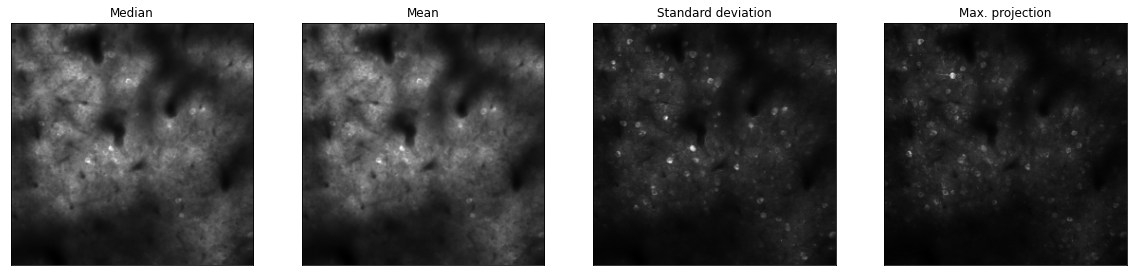

In [9]:
stack = loadtif(stack_fpaths[ifile])
filtered_stack = loadtif(filtered_stack_fpaths[ifile])
fig = plot_stack_summary(filtered_stack)
viewstacks({'raw': stack, 'filtered': filtered_stack}, suptitle=kd)

## Functional segmentation

We will now use the suite2p pipeline to identify ROIs in our field of view and compute their fluorescence timecourse.

### Determine suite2p input data

In [10]:
# Determine input filepaths (raw or filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Get the list of folders containing the input filepaths
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
logger.info(f'Suite2p input directories:\n{pprint.pformat(s2p_input_dirs)}')

 21/10/2021 18:26:15: Suite2p input directories:
['/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1']


### Set suite2p pipeline parameters

In [11]:
# Custom options
myops = {
    'tau': TAU_GCAMP6_DECAY,  # timescale mof the sensor (in our case GCaMP6s)
    'fs': fps,  # sampling rate (per plane)
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': True,  # perform PCA denoising of the registered stack prior to ROI detection 
}

ops = default_ops()  # get default run options
ops.update(myops)  # update with personal options
logger.info(f'Suite2p {version} with run options:\n{pprint.pformat(ops)}')

 21/10/2021 18:26:16: Suite2p 0.10.2 with run options:
{'1Preg': False,
 'align_by_chan': 1,
 'allow_overlap': False,
 'anatomical_only': 0,
 'aspect': 1.0,
 'baseline': 'maximin',
 'batch_size': 500,
 'bidi_corrected': False,
 'bidiphase': 0,
 'block_size': [128, 128],
 'bruker': False,
 'bruker_bidirectional': False,
 'cellprob_threshold': 0.0,
 'chan2_thres': 0.65,
 'classifier_path': 0,
 'combined': True,
 'connected': True,
 'delete_bin': False,
 'denoise': True,
 'diameter': 0,
 'do_bidiphase': False,
 'do_registration': 1,
 'fast_disk': [],
 'flow_threshold': 1.5,
 'force_refImg': False,
 'force_sktiff': False,
 'frames_include': -1,
 'fs': 3.56,
 'functional_chan': 1,
 'h5py': [],
 'h5py_key': 'data',
 'high_pass': 100,
 'ignore_flyback': [],
 'inner_neuropil_radius': 2,
 'keep_movie_raw': False,
 'lam_percentile': 50.0,
 'look_one_level_down': False,
 'max_iterations': 20,
 'max_overlap': 0.75,
 'maxregshift': 0.1,
 'maxregshiftNR': 5,
 'mesoscan': False,
 'min_neuropil_pixels

### Run suite2p

In [12]:
run_suite2p(ops=ops, db={'data_path': s2p_input_dirs}, overwrite=False)

 21/10/2021 18:26:20: suite2p output files already exist in "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/suite2p/plane0"


### Load suite2p ouput data

In [13]:
s2p_output_fpath = os.path.join(s2p_input_dirs[0], 'suite2p', 'plane0')
s2p_data = get_suite2p_data(s2p_output_fpath, withops=True)
s2p_ops = s2p_data.pop('ops')
nruns = len(s2p_ops['filelist'])
nframes_per_run = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run) == 1,  'inconsistent number of frames for each run'
nframes_per_run = nframes_per_run[0]
ntrials_per_run = nframes_per_run // nframes_per_trial

### Plot suite2p summary images

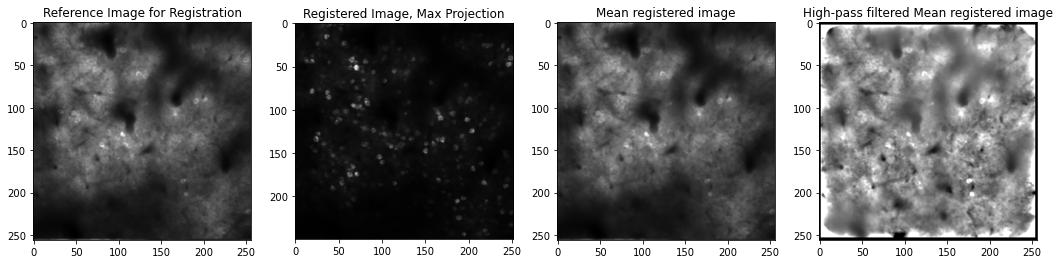

In [14]:
fig = plot_suite2p_registration_images(s2p_ops)

### Plot suite2p registration offsets

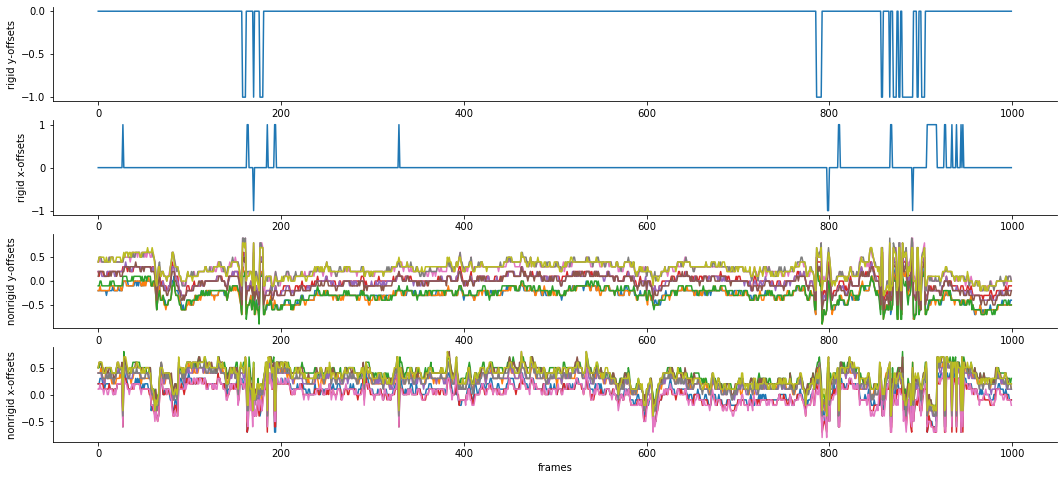

In [15]:
fig = plot_suite2p_registration_offsets(s2p_ops)

### Visualize registered stack

In [19]:
view_registered_stack(s2p_ops)

interactive(children=(IntSlider(value=11999, description='frame', max=23999), Output()), _dom_classes=('widget…

### Inspect suite2p ROIs

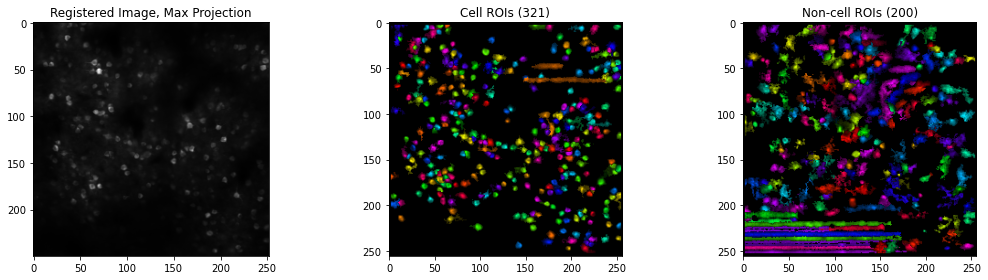

In [20]:
figs['s2p_registration'] = plot_suite2p_ROIs(s2p_data, s2p_ops)

## Post-processing

### Filter out non-cell ROIs

In [21]:
cell_data = {}
iscell, cellprob = s2p_data['iscell'].T
cell_ROI_idx = np.array(iscell.nonzero()).reshape(-1)  # ROI indexes of the cell entities
s2p_cell_data = {k: v[cell_ROI_idx] for k, v in s2p_data.items()}
del s2p_cell_data['iscell']
ncells = len(cell_ROI_idx)

### Plot distributions of morphological parameters and identify outliers to exclude

 21/10/2021 18:27:25: identified outliers:
    - 277 (ROI 409)


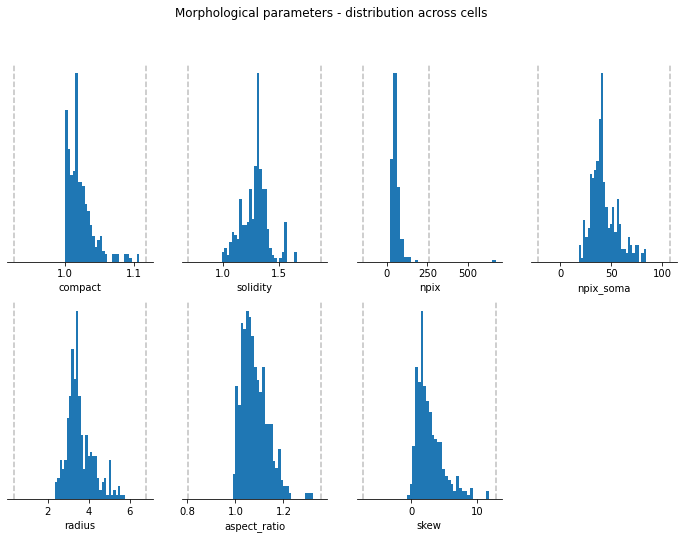

In [22]:
pkeys = [
    'compact',
    'solidity',
    'npix',
    'npix_soma',
    'radius',
    'aspect_ratio',
    'skew',
]
fig, ioutliers = plot_parameter_distributions(s2p_cell_data['stat'], pkeys, zthr=5)
s = '\n'.join([f'    - {i} (ROI {cell_ROI_idx[i]})' for i in ioutliers])
logger.info(f'identified outliers:\n{s}')

cell_ROI_idx = np.delete(cell_ROI_idx, ioutliers)
s2p_cell_data = {k: v[cell_ROI_idx] for k, v in s2p_data.items()}
ncells = len(cell_ROI_idx)

### Compute fluorescence data

We also plot the full fluorescence dataset to verify the suite2p output integrity 

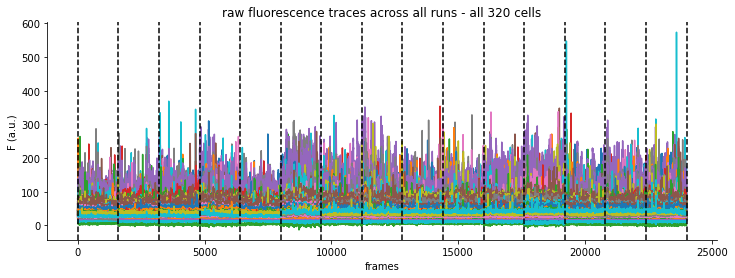

In [23]:
F = s2p_cell_data['F'] - NEUROPIL_FACTOR * s2p_cell_data['Fneu']
fig = plot_raw_traces(
    F, 'all runs', delimiters=np.arange(nruns + 1) * nframes_per_run)

### Split the data into separate runs

In [24]:
F_per_run = separate_runs(F, nruns)

### Plot fluorescence timecourse for a few runs

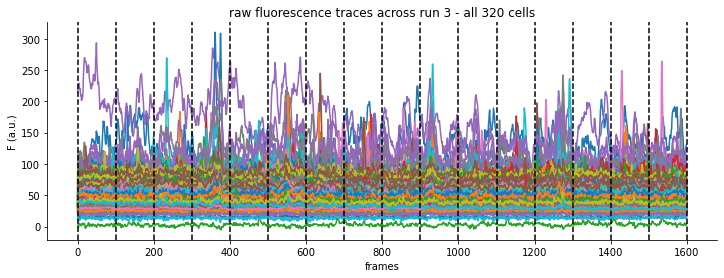

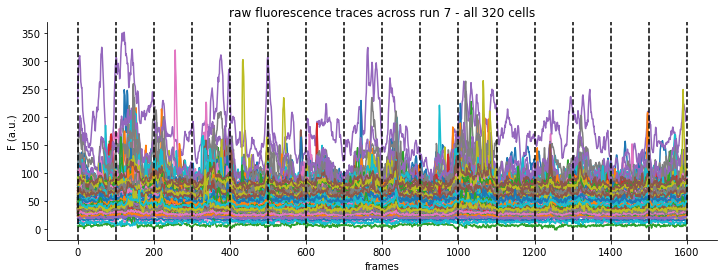

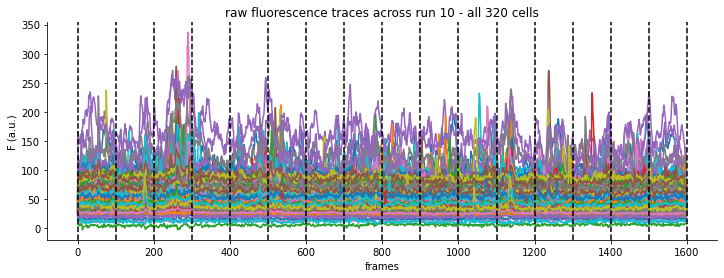

In [25]:
for irun in [3, 7, 10]:
    fig = plot_raw_traces(
        F_per_run[:, irun, :], f'run {irun}',
        delimiters=np.arange(ntrials_per_run + 1) * nframes_per_trial)

### Split the fluorescence data into separate trials 

In [26]:
F_per_trial = separate_trials(F_per_run, ntrials_per_run)

### Plot fluorescence timecourse of specific run for a few trials

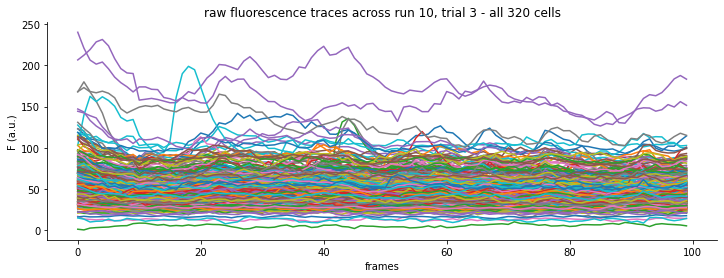

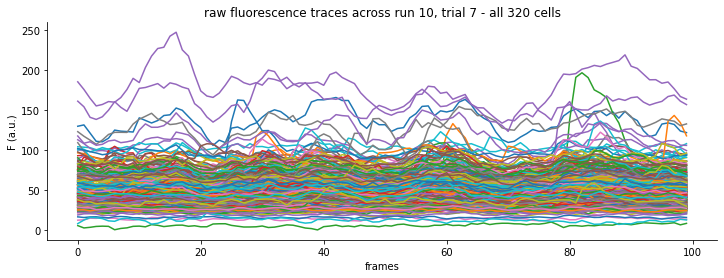

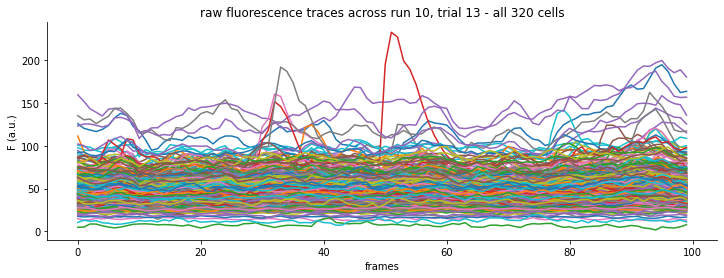

In [27]:
for itrial in [3, 7, 13]:
    fig = plot_raw_traces(F_per_trial[:, irun, itrial], f'run {irun}, trial {itrial}')

### Compute relative fluorescence change for each trial

In [28]:
dFF_per_trial = get_relative_fluorescence_change(F_per_trial, I_BASELINE)

### Plot relative fluorescence timecourse of specific run for a few trials

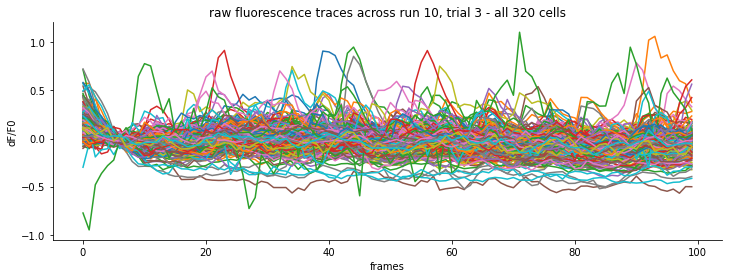

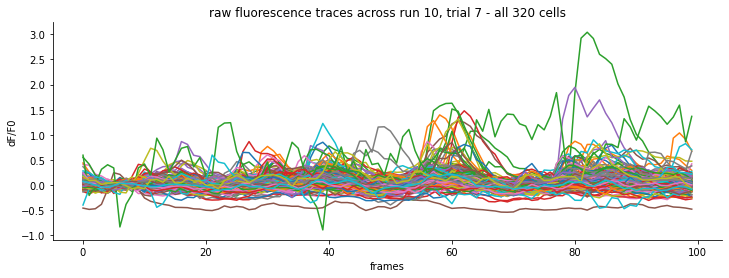

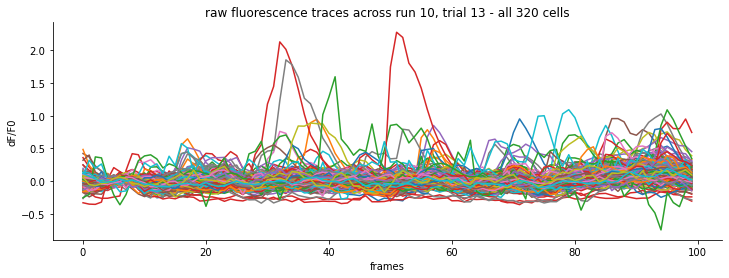

In [29]:
for itrial in [3, 7, 13]:
    fig = plot_raw_traces(dFF_per_trial[:, irun, itrial], f'run {irun}, trial {itrial}', ylabel='dF/F0')

### <span style="color:red">TODO: Substitute stim frame for each trial???</span>

### <span style="color:red">TODO: Ignore 1st trial of each run???</span>

### <span style="color:red">TODO: Remove outliers???</span>

### Classify cells by response type

 21/10/2021 18:27:47: computing z-score distributions
 21/10/2021 18:27:47: averaging
 21/10/2021 18:27:47: Identified response types classes:
    - negative: 169
    - neutral: 147
    - positive: 4


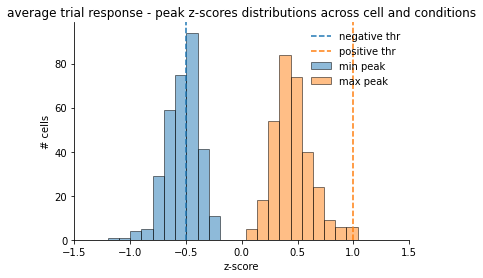

In [30]:
# Compute response type for each cell
resp_types, (zmin_dist, zmax_dist) = classify_by_response_type(dFF_per_trial, full_output=True)
s = "\n".join([f"    - {v}: {sum(resp_types == k)}" for k, v in LABEL_BY_TYPE.items()])
logger.info(f'Identified response types classes:\n{s}')
# Plot associated z-scores distributions
fig = plot_zscore_distributions(zmin_dist, zmax_dist)

### Add everything to global experiment dataframe

In [31]:
# Add cells and trial info to table
data = add_cells_to_table(info_table, cell_ROI_idx)
del data['code']
data = add_trials_to_table(data)
# Add fluorescence and time signals
# data = add_signal_to_table(data, 'F', F_per_trial)
data = add_signal_to_table(data, 'dF/F0', dFF_per_trial)
data = add_time_to_table(data)
# Add response type
data[RESP_LABEL] = resp_types[data.index.get_level_values('cell')]
# Log output
logger.info('data table:')
data

 21/10/2021 18:27:56: data table:


line  duration (s)  P (MPa)  DC (%)  run ID  ntrials  \
cell run trial frame                                                          
0    0   0     0      line3           0.2      0.8    60.0     749       16   
               1      line3           0.2      0.8    60.0     749       16   
               2      line3           0.2      0.8    60.0     749       16   
               3      line3           0.2      0.8    60.0     749       16   
               4      line3           0.2      0.8    60.0     749       16   
...                     ...           ...      ...     ...     ...      ...   
319  14  15    95     line3           0.2      0.4    50.0     753       16   
               96     line3           0.2      0.4    50.0     753       16   
               97     line3           0.2      0.4    50.0     753       16   
               98     line3           0.2      0.4    50.0     753       16   
               99     line3           0.2      0.4    50.0     753       16   

                      roi     dF/F0   time (s)  response type  
cell run trial frame                                           
0    0   0     0        0 -0.038311  -2.808989             -1  
               1        0  0.054094  -2.528090             -1  
               2        0  0.060227  -2.247191             -1  
               3        0  0.025694  -1.966292             -1  
               4        0  -0.07189  -1.685393             -1  
...                   ...       ...        ...            ...  
319  14  15    95     519 -0.071236  23.876404             -1  
               96     519 -0.029855  24.157303             -1  
               97     519 -0.074296  24.438202             -1  
               98     519 -0.111198  24.719101             -1  
               99     519 -0.102219  25.000000             -1  

[7680000 rows x 10 columns]

## Visualizing results 

### Spatial distribution of cells per response type

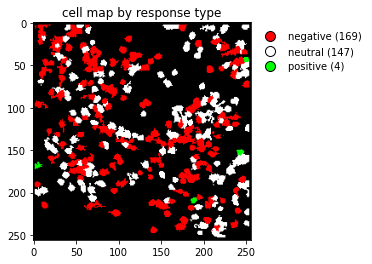

In [32]:
rtypes = data.groupby('cell').first()[RESP_LABEL]
figs['cellmap'] = plot_cell_map(s2p_cell_data['stat'], rtypes, title='cell map by response type')

### Cluster map of cell responses

/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


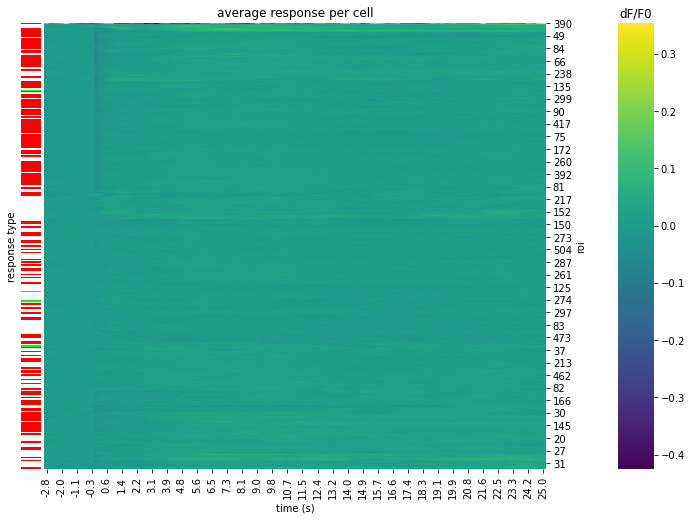

In [33]:
figs['clustermap'] = plot_experiment_heatmap(data, title='average response per cell')

### Quick fix: remove problematic ROI

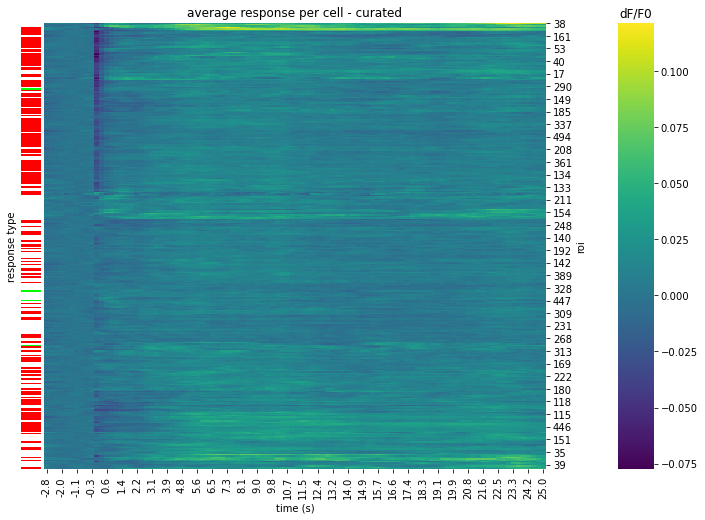

In [34]:
fig = plot_experiment_heatmap(
    data.drop([np.where(cell_ROI_idx == 390)[0][0]]),
    title='average response per cell - curated')

### Pick a random cell

In [35]:
icell = randint(0, ncells -1)

### Plot dF/F0 traces for a specific cell and run

(we use this as an opportunity to verify integrity of dataframe-based data (w.r.t. matrix-based reference)

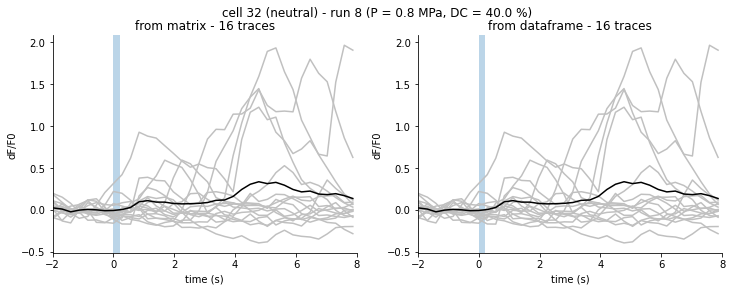

In [36]:
irun = 8
subdata = data.loc[(icell, irun)]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
P, DC = get_singleton(subdata, [P_LABEL, DC_LABEL])
fig.suptitle(f'cell {icell} ({LABEL_BY_TYPE[rtypes[icell]]}) - run {irun} (P = {P} MPa, DC = {DC} %)')
fig = plot_trial_response(dFF_per_trial[icell, irun], ax=axes[0], title='from matrix', tstim=tstim)
fig = plot_trial_response(subdata, ax=axes[1], title='from dataframe')

### Plot dF/F0 traces for a particular (cell, pressure, duty cycle) combination 

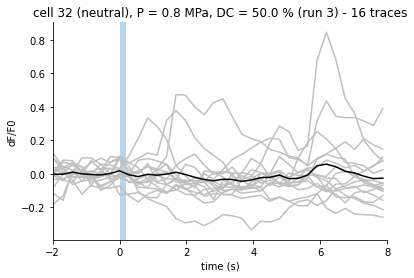

In [37]:
P, DC = 0.8, DC_REF
subdata = data[(data[P_LABEL] == P) & (data[DC_LABEL] == DC)].loc[(icell)]
irun = get_singleton(subdata, "run")
fig = plot_trial_response(
    subdata, title=f'cell {icell} ({LABEL_BY_TYPE[rtypes[icell]]}), P = {P} MPa, DC = {DC} % (run {irun})')

### Plot dF/F0 traces of all cells of a given response type for a particular (pressure, duty cycle) combination 

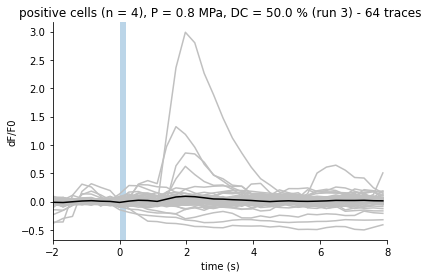

In [38]:
rtype = 1
subdata = data[(data[P_LABEL] == P) & (data[DC_LABEL] == DC) & (data[RESP_LABEL] == rtype)]
ncells_cat = len(set(subdata.index.get_level_values('cell')))
fig = plot_trial_response(
    subdata,
    title=f'{LABEL_BY_TYPE[rtype]} cells (n = {ncells_cat}), P = {P} MPa, DC = {DC} % (run {get_singleton(subdata, "run")})',
    aggkeys=['cell', 'trial'])